In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%pip install opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import glob

In [5]:
from scipy import ndimage, misc
from skimage import io
from skimage import transform 
from skimage.util import img_as_ubyte

In [6]:
def zoom_at(img, zoom=1, angle=0, coord=None):
    
    cy, cx = [ i/2 for i in img.shape[:-1] ] if coord is None else coord[::-1]
    
    rot_mat = cv2.getRotationMatrix2D((cx,cy), angle, zoom)
    result = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    return result

In [99]:
#nama mutu : A, AB, B, BC, E
mutu = 'A'

In [100]:
raw_datas = []
for name in glob.glob("gdrive/MyDrive/tugas-akhir-dhifaf/dataset-ta/cropped-raw-all/"+mutu+"/*.jpg") :
  raw_data = cv2.imread(name)
  raw_data = cv2.resize(raw_data, (256, 256))
  raw_datas.append(raw_data)

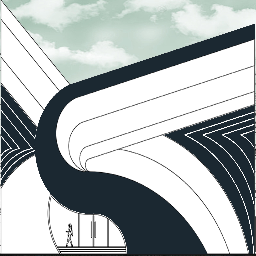

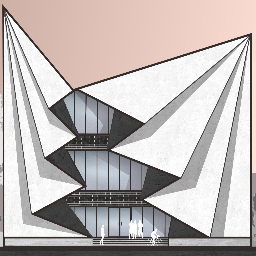

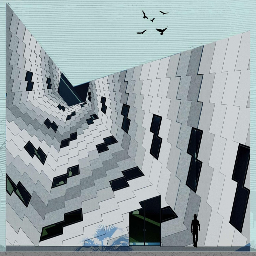

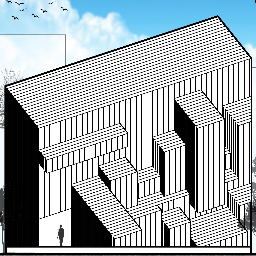

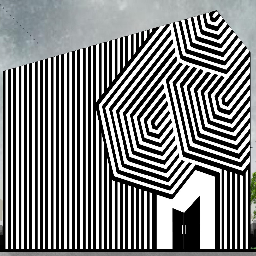

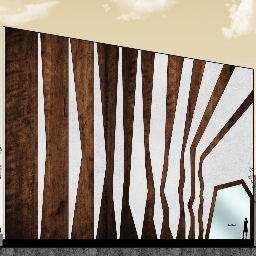

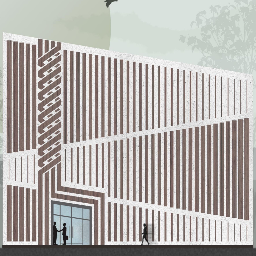

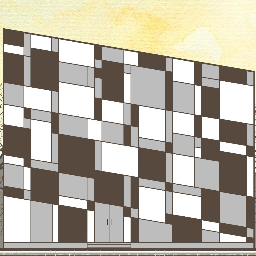

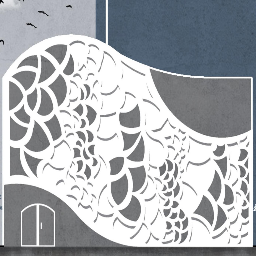

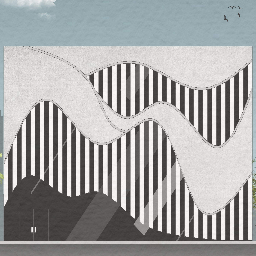

In [101]:
for i in range(len(raw_datas)):
  cv2_imshow(raw_datas[i])

In [102]:
import random

In [103]:
def rotation(img, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img

In [104]:
augmentation_rotate = []
for img in raw_datas:
  for i in range(60):
    # height, width = img.shape[:2]
    # angle = random.randint(0, 359)
    # rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2),angle,1)
    # rotated_image = cv2.warpAffine(img, rotation_matrix, (width, height))
    # rotated_image = ndimage.rotate(img, angle)
    # final_image = cv2.resize(rotated_image, (256, 256))
    final_image = rotation(img, 360)
    # cv2_imshow(final_image)
    # print("\n")
    augmentation_rotate.append(final_image)

In [105]:
augmentation_translate = []
# for img in augmentation_rotate:
for img in raw_datas:
  for i in range(5):
    height, width = img.shape[:2]
    range_devider = [-12, -11, -10, -9, -8, 8, 9, 10, 11, 12]
    devider = random.choice(range_devider)
    new_height, new_width = height / devider, width / devider
    T = np.float32([[1, 0, new_width], [0, 1, new_height]])
    img_translation = cv2.warpAffine(img, T, (width, height))
    # cv2_imshow(img_translation)
    # print("\n")
    augmentation_translate.append(img_translation)


In [106]:
augmentation_shearing = []
# for img in raw_datas:
#   for i in range(100):
# for img in augmentation_translate:
for img in raw_datas:
  for i in range(10):
    shear_range = random.uniform(-0.2, 0.2)
    afine_tf = transform.AffineTransform(shear=shear_range)
    img_shearing = transform.warp(img, inverse_map=afine_tf)
    result = img_as_ubyte(img_shearing)
    # cv2_imshow(result)
  # print("\n")
  augmentation_shearing.append(result)

In [107]:
augmentation_zooming = []
# for img in augmentation_shearing:
for img in raw_datas:
  for i in range(5):
    zoom_range = random.uniform(0.2, 1.5)
    zoom = zoom_at(img, zoom_range)
    # cv2_imshow(zoom)
    # print("\n")
    augmentation_zooming.append(zoom)

In [108]:
mid_arr = raw_datas + augmentation_shearing + augmentation_rotate + augmentation_translate + augmentation_zooming

In [109]:
def colorjitter(img, cj_type="b"):
    '''
    ### Different Color Jitter ###
    img: image
    cj_type: {b: brightness, s: saturation, c: constast}
    '''
    if cj_type == "b":
        # value = random.randint(-50, 50)
        value = np.random.choice(np.array([-50, -40, -30, 30, 40, 50]))
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        if value >= 0:
            lim = 255 - value
            v[v > lim] = 255
            v[v <= lim] += value
        else:
            lim = np.absolute(value)
            v[v < lim] = 0
            v[v >= lim] -= np.absolute(value)

        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
        return img
    
    elif cj_type == "s":
        # value = random.randint(-50, 50)
        value = np.random.choice(np.array([-50, -40, -30, 30, 40, 50]))
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        if value >= 0:
            lim = 255 - value
            s[s > lim] = 255
            s[s <= lim] += value
        else:
            lim = np.absolute(value)
            s[s < lim] = 0
            s[s >= lim] -= np.absolute(value)

        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
        return img
    
    elif cj_type == "c":
        brightness = 10
        contrast = random.randint(40, 100)
        dummy = np.int16(img)
        dummy = dummy * (contrast/127+1) - contrast + brightness
        dummy = np.clip(dummy, 0, 255)
        img = np.uint8(dummy)
        return img


def noisy(img, noise_type="gauss"):
    '''
    ### Adding Noise ###
    img: image
    cj_type: {gauss: gaussian, sp: salt & pepper}
    '''
    if noise_type == "gauss":
        image=img.copy() 
        mean=0
        st=0.7
        gauss = np.random.normal(mean,st,image.shape)
        gauss = gauss.astype('uint8')
        image = cv2.add(image,gauss)
        return image
    
    elif noise_type == "sp":
        image=img.copy() 
        prob = 0.05
        if len(image.shape) == 2:
            black = 0
            white = 255            
        else:
            colorspace = image.shape[2]
            if colorspace == 3:  # RGB
                black = np.array([0, 0, 0], dtype='uint8')
                white = np.array([255, 255, 255], dtype='uint8')
            else:  # RGBA
                black = np.array([0, 0, 0, 255], dtype='uint8')
                white = np.array([255, 255, 255, 255], dtype='uint8')
        probs = np.random.random(image.shape[:2])
        image[probs < (prob / 2)] = black
        image[probs > 1 - (prob / 2)] = white
        return image

In [110]:
augmentation_brightness = []
for img in mid_arr:
  # init_value = 30
  # value = int(random.uniform(-init_value, init_value))
  # img = img + value
  # img[:,:,:][img[:,:,:]>255]  = 255
  # img[:,:,:][img[:,:,:]<0]  = 0
  img = colorjitter(img, cj_type="b")
  result = img
  # cv2_imshow(result)
  # print("\n")
  augmentation_brightness.append(result)

In [111]:
augmentation_contrast = []
for img in mid_arr:
  # init_value = 30
  # value = int(random.uniform(-init_value, init_value))
  # img = img + value
  # img[:,:,:][img[:,:,:]>255]  = 255
  # img[:,:,:][img[:,:,:]<0]  = 0
  img = colorjitter(img, cj_type="c")
  result = img
  # cv2_imshow(result)
  # print("\n")
  augmentation_contrast.append(result)

In [112]:
augmentation_gaussian = []
for img in mid_arr:
  # init_value = 30
  # value = int(random.uniform(-init_value, init_value))
  # img = img + value
  # img[:,:,:][img[:,:,:]>255]  = 255
  # img[:,:,:][img[:,:,:]<0]  = 0
  img = noisy(img, noise_type="gauss")
  result = img
  # cv2_imshow(result)
  # print("\n")
  augmentation_gaussian.append(result)

In [113]:
final_arr = raw_datas + augmentation_shearing + augmentation_rotate + augmentation_translate + augmentation_zooming + augmentation_brightness + augmentation_contrast + augmentation_gaussian

In [114]:
# augmentation_brightness = []
# for img in augmentation_rotate:
#   low = 0.3
#   high = 3
#   value = random.uniform(low, high)
#   hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#   hsv = np.array(hsv, dtype = np.float64)
#   hsv[:,:,1] = hsv[:,:,1]*value
#   hsv[:,:,1][hsv[:,:,1]>255]  = 255
#   hsv[:,:,2] = hsv[:,:,2]*value 
#   hsv[:,:,2][hsv[:,:,2]>255]  = 255
#   hsv = np.array(hsv, dtype = np.uint8)
#   result = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
#   # cv2_imshow(result)
#   # print("\n")
#   augmentation_brightness.append(result)

In [115]:
len(final_arr)
# data A - ex 1 = 601
# data AB - ex 1 = 2404
# data B - ex 1 = 1202
# data BC - ex 1 = 1202
# data E - ex 1 = 1202

# data gabungan A - ex 1 = 4010
# data gabungan AB - ex 1 = 8421
# data gabungan B - ex 1 = 6015
# data gabungan BC - ex 1 = 1203
# data gabungan E - ex 1 = 1203

# data gabungan A - ex 1 = 2880
# data gabungan AB - ex 1 = 6048
# data gabungan B - ex 1 = 4320
# data gabungan BC - ex 1 = 864
# data gabungan E - ex 1 = 864

2880

In [116]:
for i, img in enumerate(final_arr) :
  isSaved = cv2.imwrite("gdrive/MyDrive/tugas-akhir-dhifaf/dataset-ta/all-aug-ex-2/" + mutu + "/img-" + mutu + "-" + str(i) + ".jpg", img)
  if isSaved :
    print("saved in : " + "gdrive/MyDrive/tugas-akhir-dhifaf/dataset-ta/all-aug-ex-2/" + mutu + "/img-" + mutu + "-" + str(i) + ".jpg")
  else :
    print("ERROR ")
    break

saved in : gdrive/MyDrive/tugas-akhir-dhifaf/dataset-ta/all-aug-ex-2/A/img-A-0.jpg
saved in : gdrive/MyDrive/tugas-akhir-dhifaf/dataset-ta/all-aug-ex-2/A/img-A-1.jpg
saved in : gdrive/MyDrive/tugas-akhir-dhifaf/dataset-ta/all-aug-ex-2/A/img-A-2.jpg
saved in : gdrive/MyDrive/tugas-akhir-dhifaf/dataset-ta/all-aug-ex-2/A/img-A-3.jpg
saved in : gdrive/MyDrive/tugas-akhir-dhifaf/dataset-ta/all-aug-ex-2/A/img-A-4.jpg
saved in : gdrive/MyDrive/tugas-akhir-dhifaf/dataset-ta/all-aug-ex-2/A/img-A-5.jpg
saved in : gdrive/MyDrive/tugas-akhir-dhifaf/dataset-ta/all-aug-ex-2/A/img-A-6.jpg
saved in : gdrive/MyDrive/tugas-akhir-dhifaf/dataset-ta/all-aug-ex-2/A/img-A-7.jpg
saved in : gdrive/MyDrive/tugas-akhir-dhifaf/dataset-ta/all-aug-ex-2/A/img-A-8.jpg
saved in : gdrive/MyDrive/tugas-akhir-dhifaf/dataset-ta/all-aug-ex-2/A/img-A-9.jpg
saved in : gdrive/MyDrive/tugas-akhir-dhifaf/dataset-ta/all-aug-ex-2/A/img-A-10.jpg
saved in : gdrive/MyDrive/tugas-akhir-dhifaf/dataset-ta/all-aug-ex-2/A/img-A-11.jpg
sa

In [124]:
dataset_path = r"gdrive/MyDrive/tugas-akhir-dhifaf/dataset-ta/all-aug-ex-1-1"

In [121]:
%pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [125]:
import splitfolders
splitfolders.ratio(dataset_path, output="gdrive/MyDrive/tugas-akhir-dhifaf/dataset-ta/output-all-aug-ex-1-1", seed=1337, ratio=(.8, 0.1,0.1)) 

Streaming output truncated to the last 5000 lines.
Copying files: 970 files [01:00, 48.85 files/s]

Copying files: 975 files [01:00, 48.44 files/s]

Copying files: 981 files [01:00, 51.34 files/s]

Copying files: 987 files [01:00, 51.32 files/s]

Copying files: 994 files [01:00, 54.36 files/s]

Copying files: 1000 files [01:00, 53.98 files/s]

Copying files: 1006 files [01:00, 47.86 files/s]

Copying files: 1011 files [01:00, 47.51 files/s]

Copying files: 1016 files [01:00, 43.70 files/s]

Copying files: 1022 files [01:01, 46.95 files/s]

Copying files: 1029 files [01:01, 47.13 files/s]

Copying files: 1035 files [01:01, 48.99 files/s]

Copying files: 1042 files [01:01, 50.23 files/s]

Copying files: 1048 files [01:01, 48.39 files/s]

Copying files: 1055 files [01:01, 52.91 files/s]

Copying files: 1061 files [01:01, 50.44 files/s]

Copying files: 1067 files [01:01, 47.35 files/s]

Copying files: 1072 files [01:02, 45.65 files/s]

Copying files: 1077 files [01:02, 46.73 files/s]

Copy